In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re
import matplotlib.colors as mcolors
import csv
from scipy.signal import savgol_filter, find_peaks
from scipy.optimize import curve_fit
from functions import *

def find_closest(value, series):
    return series.iloc[(series - value).abs().argsort()[:1]].values[0]

def find_edge_position(energy, intensity, monoE_min, monoE_max, smoothing_window, polyorder):
    """
    Finds the edge position in the given energy vs. intensity data obtained in Fluorescen mode###
        
      Parameter - energy: numpy array of energy values
    - intensity: numpy array of intensity values
    - smoothing_window: window size for Savitzky-Golay filter (default is 11)
    - polyorder: polynomial order for Savitzky-Golay filter (default is 3)

    Returns:
    - edge_position_idx: index of the detected edge position
    """
    # Step 1: Normalize the intensity data
    normalized_data = intensity / np.max(intensity)
    
    # smooth the data
    #smoothed_data = savgol_filter(normalized_data, smoothing_window, polyorder)
    
    # Step 2: Calculate the first derivative
    first_derivative = np.gradient(normalized_data)
    
    # Step 3: Find the index of the maximum in the first derivative
    max_index = np.argmax(first_derivative)

    if monoE_min <= energy[max_index] <= monoE_max:
        edge_position = energy[max_index]  # Access energy value directly using the index
        
    else:
        edge_position = 0
        print("Warning: No valid maximum found within the specified energy range.")
    
    
    return edge_position


def find_edge_position_PVfit(energy, intensity, monoE_min, monoE_max, smoothing_window, polyorder):
    """
    Finds the edge position in the given energy vs. intensity data obtained in Fluorescen mode###
        
      Parameter - energy: numpy array of energy values
    - intensity: numpy array of intensity values
    - smoothing_window: window size for Savitzky-Golay filter (default is 11)
    - polyorder: polynomial order for Savitzky-Golay filter (default is 3)

    Returns:
    - edge_position_idx: index of the detected edge position after fitting with a gaussian peak
    """
    # Step 1: Normalize the intensity data
    normalized_data = intensity / np.max(intensity)
    # smooth data
    smoothed_data = savgol_filter(normalized_data, smoothing_window, polyorder)
   
    # Step 2: Calculate the first derivative
    first_derivative_smooth = np.gradient(smoothed_data)
    first_derivative = np.gradient(normalized_data)

    # Step 3: Find the index of the maximum in the first derivative
    max_index = np.argmax(first_derivative)
    
    # Step 4: Check if the max_index falls within the specified range
    if monoE_min <= energy[max_index] <= monoE_max:
        # Step 5: Fitting the curve to obtain the maximum of the first derivative within the range
        # Limit the data to the specified energy range
        edge = energy[max_index]
        energy_range_mask = (energy >= edge-5) & (energy <= edge+5)
        energy_limited = energy[energy_range_mask]
        first_derivative_smooth_limited = first_derivative_smooth[energy_range_mask]
              
        
        # Initial guess for the pseudo-Voigt parameters: [A, x0, sigma, gamma, eta]
        Amplitud = 1
        x0 = energy[max_index]
        sigma = np.std(energy) / 10
        gamma = sigma
        eta = 0.5
        initial_guess = [Amplitud, x0, sigma, gamma, eta]

        try:
            # popt: This is an array of the optimal values for the parameters of the pseudo_voigt function
            # _: This is an array of the estimated covariance of popt, which is often ignored
            # *popt syntax unpacks the optimized parameters so that they are passed
            #  as individual arguments to the pseudo_voigt function
            ##without masking the data
            #popt, _ = curve_fit(pseudo_voigt, energy, first_derivative_smooth, p0=initial_guess)
            #Amplitud, x0, sigma, gamma, eta = popt
            #fit_curve = pseudo_voigt(energy, *popt)

            ##masking the data to only fit a peak close to the maximum value
            popt, _ = curve_fit(pseudo_voigt, energy_limited, first_derivative_smooth_limited, p0=initial_guess)
            Amplitud, x0, sigma, gamma, eta = popt
            fit_curve = pseudo_voigt(energy, *popt)


            # The edge position is the center of the fitted pseudo-Voigt curve
            edge_position = x0
            
        except RuntimeError:
            # Handle case where the fitting fails
            edge_position = energy[max_index]
            fit_curve = first_derivative
            print(f'The Edge position is obtained without fitting the first derivative with the PV function')

    else:
        # Handle the case where max_index is outside the specified range
        edge_position = 0
        fit_curve = first_derivative
        print("Warning: max_index is outside the specified energy range. Curve was not fitted.")
    
    return edge_position, fit_curve

def find_edge_position_second_derivative(energy, intensity, monoE_min, monoE_max, smoothing_window, polyorder):
    """
    Finds the edge position in the given energy vs. intensity data obtained in Fluorescen mode###
        
      Parameter - energy: numpy array of energy values
    - intensity: numpy array of intensity values
    - smoothing_window: window size for Savitzky-Golay filter (default is 11)
    - polyorder: polynomial order for Savitzky-Golay filter (default is 3)

    Returns:
    - edge_position_idx: index of the detected edge position
    """
    # Step 1: Normalize the intensity data
    normalized_data = intensity / np.max(intensity)
    
    smoothed_data = savgol_filter(normalized_data, smoothing_window, polyorder)
    #first_derivative = np.gradient(smoothed_data)
    first_derivative = np.gradient(normalized_data)
    
    # Step 3: Find the index of the maximum in the first derivative
    max_index = np.argmax(first_derivative)
    
    ## Step 4: Calculate the second derivative
    second_derivative = np.gradient(first_derivative)
    
    ## Step 5: Find the zero-crossing in the second derivative near the maximum
    zero_crossing_indices = np.where(np.diff(np.sign(second_derivative)))[0]
    
    # Filter zero_crossing_indices to those between monoE_min and monoE_max
    valid_indices = [idx for idx in zero_crossing_indices if monoE_min <= energy[idx] <= monoE_max]
    
    if not valid_indices:
        raise ValueError("No valid edge position found within the specified energy range.")
    
    # Step 7: Find the zero-crossing closest to the maximum in the first derivative
    edge_position_idx = valid_indices[np.abs(np.array(valid_indices) - max_index).argmin()]
    edge_position = energy[edge_position_idx]  # Access energy value directly using the index
    
    return edge_position #, second_derivative

def gaussian(x, A, x0, sigma):
    """
    Creates a Gaussian curve with the given parameters
    A is the amplitude.
    sigma is the standard deviation
    x0 is the center of the peak
    x is the data
    Returns:
    The Gaussian curve
    """
    Gaussian = A * np.exp(-(x - x0)**2 / (2 * sigma**2))
    return Gaussian

def lorentzian(x, A, x0, gamma):
    """
    Creates a Lorentzian curve with the given parameters
    A is the amplitude.
    gamma is the half-width at half-maximum
    x0 is the center of the peak
    x is the data
    Returns:
    The Lorentzian curve
    """
    Lorentzian = A * (gamma**2) / ((x - x0)**2 + gamma**2)
    return Lorentzian

def pseudo_voigt(x, A, x0, sigma, gamma, eta):
    """
    Creates a Pseudo Voigt curve with the given parameters
    to fit the data
    x is the data to be fitted
    A is the amplitud
    x0 is the center of the curve
    sigma is the standard deviation for the Gaussian curve
    gamma is the half-width at half-maximum for the Lorenztian
    eta is the between 0-1 determines the Lorentzian contribution of the PV curve
    Returns:
    The PV curve fitting
    """
    PV = eta * lorentzian(x, A, x0, gamma) + (1 - eta) * gaussian(x, A, x0, sigma)
    return PV

## References from literature to calculate the edge position related to an oxidation state

### Ni XAS Ref from literature - Extraction of the edge position 

./Ni_REF_XAS.dat


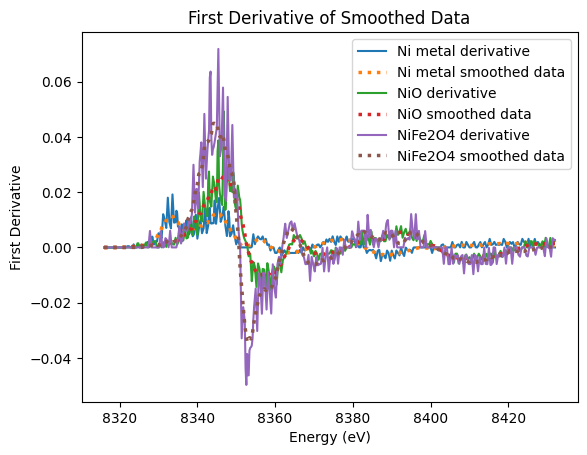

Reference,Edge Energy (eV),Edge Energy (eV)_PVfit_of 1derivative, Edge Energy (eV)_2derivative 

Ni metal,8333.6,8333.78257810867,8333.6 

NiO,8346.8,8346.390239386981,8346.8 

NiFe2O4,8345.4,8344.699838628689,8345.2 

Data saved to Ni_REF_XAS_position_derivative.dat


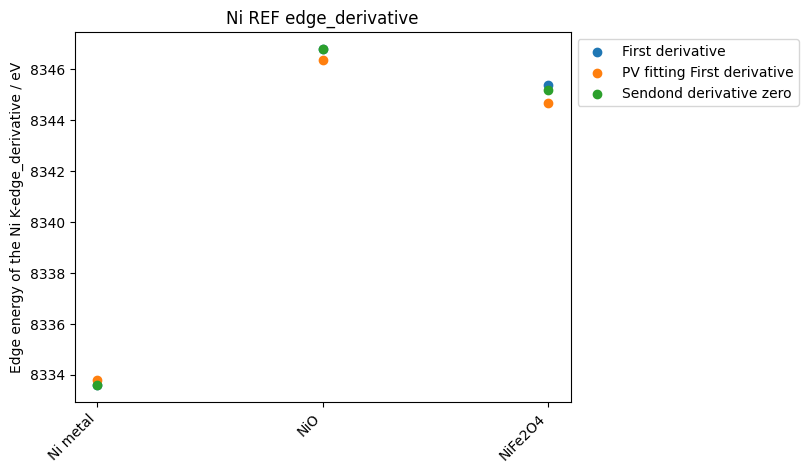

In [8]:
search_string = "Ni_REF_XAS.dat"

monoE_min = 8325
monoE_max = 8352

#edge = 8333
#smooth = "no"
# Ni K-edge is at 8.33 KeV

#Smoothing parameter needed 
# smoothing_window: controls the number of points used to fit each polynomial. 
# !should always be an odd number
# polyorder: defines the degree of the polynomial used
smoothing_window, polyorder = 17, 1

# Walk through the current directory and subdirectories
for root, dirs, files in os.walk("."):
    for i, file in enumerate(files):
        if search_string in file:
            file_path = os.path.join(root, file)                    
print(file_path)

result_df = pd.read_csv(file_path, sep='\t')

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=(result_df.shape[1]-1) / 2)

energ_calib_Ni_REF_XAS_list = []

first_derivative_list = []  # To store the first derivatives of all curves

if 'Energy' in result_df.columns:
    # Get a list of columns excluding 'Energy'
    columns_to_process = [col for col in result_df.columns if col != 'Energy']
    
    for column in columns_to_process:
        for idx, value in enumerate(result_df[column]):
            edge_position_Ni = find_edge_position(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            
            ## Fitting the first derivative to obtain the maximum position of the PV curve
            edge_position_fit_Ni, fit_curve = find_edge_position_PVfit(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            
            ## Calculate with the second derivative
            edge_position_2nd_derivative_Ni = find_edge_position_second_derivative(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            #edge_position_2nd_derivative, second_derivative = find_edge_position_second_derivative(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            
            color = cmap(norm(idx//2))  # Use the same color for pairs
            
            x = result_df['Energy']
            result_df["I"] = result_df[column] 
            y = -0.0*idx + (result_df["I"])

        # Apply Savitzky-Golay filter to smooth the data
        smoothed_data_Ni = savgol_filter(result_df["I"], smoothing_window, polyorder)
        
        # Compute the first derivative of data and the smoothed data
        first_derivative_data_Ni = np.gradient(result_df["I"])
        first_derivative_smooth_Ni = np.gradient(smoothed_data_Ni)

        # Plot the first derivative
        plt.plot(x, first_derivative_data_Ni, label=f'{column} derivative', linewidth=1.5 )
        plt.plot(x, first_derivative_smooth_Ni, label=f'{column} smoothed data', linestyle='dotted', linewidth=2.5 )
        #plt.plot(x, fit_curve, label=f'{column} fitted derivative', linestyle= 'solid', linewidth=1.5 )
        #plt.plot(x, second_derivative, label=f'{column} Second derivative', linestyle= ':', linewidth=1.5 )
            
        energ_calib_Ni_REF_XAS_list.append((column, float(edge_position_Ni), float(edge_position_fit_Ni), float(edge_position_2nd_derivative_Ni)))
        #energ_calib_Ni_REF_XAS_list.append((column,float(edge_position)))#, float(edge_position_fit)))
        
#print(energ_calib_Ni_REF_XAS_list)    
plt.xlabel('Energy (eV)')
plt.ylabel('First Derivative')
plt.title('First Derivative of Smoothed Data')
plt.legend()
#plt.xlim(8320,8380)
plt.show()

#Save the edge data in a new file
filename = "Ni_REF_XAS_position_derivative.dat"  #'sample_data.dat'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write the header
    file.write('Reference,Edge Energy (eV),Edge Energy (eV)_PVfit_of 1derivative, Edge Energy (eV)_2derivative \n')
    print(f'Reference,Edge Energy (eV),Edge Energy (eV)_PVfit_of 1derivative, Edge Energy (eV)_2derivative \n')
    # Write each tuple in the data
    for condition, energy, energy_fit, energy2_derivative in energ_calib_Ni_REF_XAS_list:
        file.write(f'{condition},{energy},{energy_fit},{energy2_derivative} \n')
        print(f'{condition},{energy},{energy_fit},{energy2_derivative} \n')

print(f'Data saved to {filename}')


# Extract x and y values
x_labels = [item[0] for item in energ_calib_Ni_REF_XAS_list]
y_1_derivative = [item[1] for item in energ_calib_Ni_REF_XAS_list]
y2_fit_1_derivative = [item[2] for item in energ_calib_Ni_REF_XAS_list]
y3_2_derivative = [item[3] for item in energ_calib_Ni_REF_XAS_list]

# Create a scatter plot
plt.scatter(x_labels, y_1_derivative, label = "First derivative")
plt.scatter(x_labels, y2_fit_1_derivative, label = "PV fitting First derivative")
plt.scatter(x_labels, y3_2_derivative, label = "Sendond derivative zero")
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Edge energy of the Ni K-edge_derivative / eV")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Ni REF edge_derivative")
plt.savefig('Ni_REF_XAS_edge_derivative.png')

### Fe XAS Ref from literature- Extraction of the edge position

./Fe_REF_XAS.dat


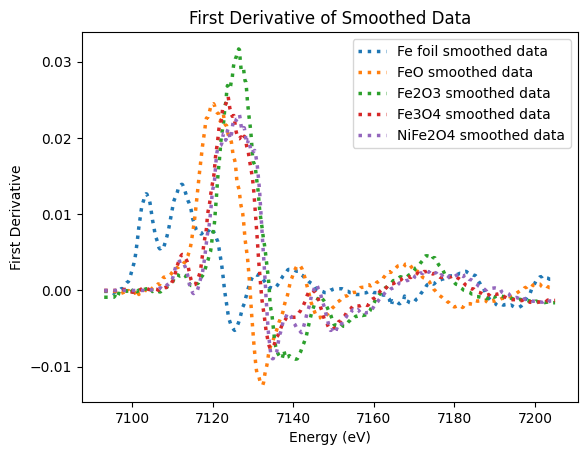

Reference,Edge Energy (eV),Edge Energy (eV)_PVfit_of 1derivative, Edge Energy (eV)_2derivative 



ValueError: not enough values to unpack (expected 4, got 2)

In [14]:
search_string = "Fe_REF_XAS.dat"

monoE_min = 7100
monoE_max = 7130 
#edge = 7.112
# Fe K-edge is at 7.112 KeV
#smooth = "yes"

#Smoothing parameter needed 
# smoothing_window: controls the number of points used to fit each polynomial. 
# !should always be an odd number
# polyorder: defines the degree of the polynomial used
smoothing_window, polyorder = 17, 1

# Walk through the current directory and subdirectories
for root, dirs, files in os.walk("."):
    for i, file in enumerate(files):
        if search_string in file:
            file_path = os.path.join(root, file)                   
print(file_path)

result_df = pd.read_csv(file_path, sep='\t')
#print(result_df.head(4))

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=(result_df.shape[1]-1) / 2)
energ_calib_Fe_REF_XAS_list = []

if 'Energy' in result_df.columns:
    # Get a list of columns excluding 'Energy'
    columns_to_process = [col for col in result_df.columns if col != 'Energy']
    
    for column in columns_to_process:
        for idx, value in enumerate(result_df[column]):
            edge_position_Fe = find_edge_position(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            
            ## Fitting the first derivative to obtain the maximum position of the PV curve
            #edge_position_fit_Fe, fit_curve = find_edge_position_PVfit(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            
            ## Calculate with the second derivative
            edge_position_2nd_derivative_Fe = find_edge_position_second_derivative(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            #edge_position_2nd_derivative, second_derivative = find_edge_position_second_derivative(result_df['Energy'].values, result_df[column].values, monoE_min, monoE_max, smoothing_window, polyorder)
            
            color = cmap(norm(idx//2))  # Use the same color for pairs
            
            x = result_df['Energy']
            result_df["I"] = result_df[column] 
            y = -0.0*idx + (result_df["I"])

        # Apply Savitzky-Golay filter to smooth the data
        smoothed_data_Fe = savgol_filter(result_df["I"], smoothing_window, polyorder)
        
        # Compute the first derivative of data and the smoothed data
        first_derivative_data_Fe = np.gradient(result_df["I"])
        first_derivative_smooth_Fe = np.gradient(smoothed_data_Fe)

        # Plot the first derivative
        #plt.plot(x, first_derivative_data_Fe, label=f'{column} derivative', linewidth=1.5 )
        plt.plot(x, first_derivative_smooth_Fe, label=f'{column} smoothed data', linestyle='dotted', linewidth=2.5 )
        #plt.plot(x, fit_curve, label=f'{column} fitted derivative', linestyle= 'solid', linewidth=1.5 )
        #plt.plot(x, second_derivative, label=f'{column} Second derivative', linestyle= ':', linewidth=1.5 )
            
        #energ_calib_Fe_REF_XAS_list.append((column, float(edge_position_Fe), float(edge_position_fit_Fe), float(edge_position_2nd_derivative_Fe)))
        energ_calib_Fe_REF_XAS_list.append((column,float(edge_position_Fe)))#, float(edge_position_fit)))
        
#print(energ_calib_Fe_REF_XAS_list)    
plt.xlabel('Energy (eV)')
plt.ylabel('First Derivative')
plt.title('First Derivative of Smoothed Data')
plt.legend()

plt.show()

#Save the edge data in a new file
filename = "Fe_REF_XAS_position_derivative.dat"  #'sample_data.dat'

# Open the file in write mode
with open(filename, 'w') as file:
    # Write the header
    file.write('Reference,Edge Energy (eV),Edge Energy (eV)_PVfit_of 1derivative, Edge Energy (eV)_2derivative \n')
    print(f'Reference,Edge Energy (eV),Edge Energy (eV)_PVfit_of 1derivative, Edge Energy (eV)_2derivative \n')
    # Write each tuple in the data
    for condition, energy, energy_fit, energy2_derivative in energ_calib_Fe_REF_XAS_list:
        file.write(f'{condition},{energy},{energy_fit},{energy2_derivative} \n')
        print(f'{condition},{energy},{energy_fit},{energy2_derivative} \n')

print(f'Data saved to {filename}')

# Extract x and y values
x_labels = [item[0] for item in energ_calib_Fe_REF_XAS_list]
y_1_derivative = [item[1] for item in energ_calib_Fe_REF_XAS_list]
y2_fit_1_derivative = [item[2] for item in energ_calib_Fe_REF_XAS_list]
y3_2_derivative = [item[3] for item in energ_calib_Fe_REF_XAS_list]

# Create a scatter plot
plt.scatter(x_labels, y_1_derivative, label = "First derivative")
plt.scatter(x_labels, y2_fit_1_derivative, label = "PV fitting First derivative")
plt.scatter(x_labels, y3_2_derivative, label = "Sendond derivative zero")
plt.ylabel ("Edge energy of the Fe K-edge_derivative / eV")
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF edge_derivative")
plt.savefig('Fe_REF_XAS_edge_derivative.png')


### Cu XAS Ref from literature- Extraction of the edge position

002_S7-NiFe-6Sm_Activation_2
003_S7-NiFe-6Sm_Reaction_1
004_S7-NiFe-6Sm_PM_RT_2
S7-FeNi-6Sm_Activation_ramp_1


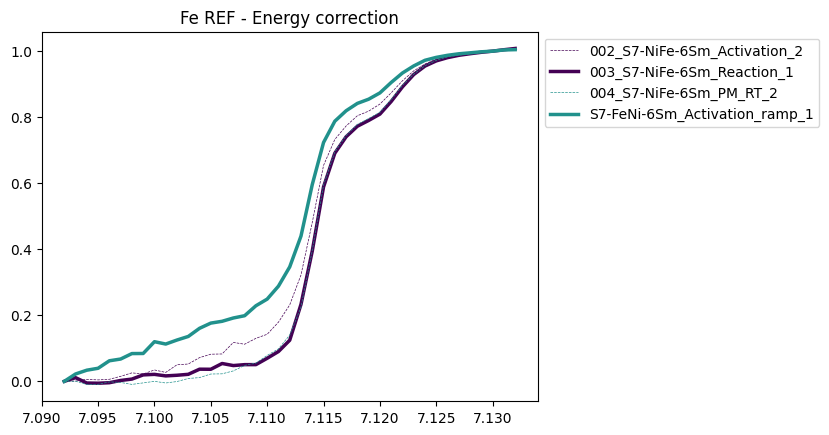

In [ ]:
search_string = "Fe_REF_merged"
var1="ionch1" # diode1 / roiX
var2="mcaRt" # AS_IC / mcaLt

monoE_min = 7.08
monoE_max = 7.13
edge = 7.112
smooth = "yes"
# Fe K-edge is at 7.112 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Cu_REF_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)
    energy_position_ref_data = find_edge_position(result_df['monoE'].values, result_df["I_norm"].values, monoE_min, monoE_max, smooth)

    #target_value = 0.5
    #idx_before = result_df[result_df["I_norm"] <= target_value].index[-1]
    #idx_after = result_df[result_df["I_norm"] > target_value].index[0]
    #x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    #x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    #interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Cu_REF_list.append((label,float(energy_position_ref_data)))


    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
#plt.ylim([1.75,2.93])
#plt.xlim([7.15,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF - Energy correction")

plt.savefig('Fe_REF_NEXAFS.png')


002_S7-NiFe-6Sm_Activation_2: has the edge at 7.1130, the energy shift is -0.001
003_S7-NiFe-6Sm_Reaction_1: has the edge at 7.1140, the energy shift is -0.002
004_S7-NiFe-6Sm_PM_RT_2: has the edge at 7.1140, the energy shift is -0.002
S7-FeNi-6Sm_Activation_ramp_1: has the edge at 7.1130, the energy shift is -0.001


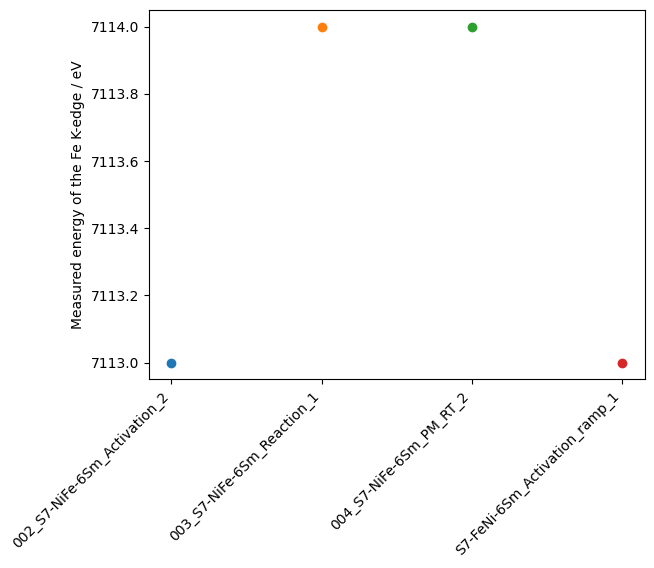

In [ ]:
for (lab, en) in energ_calib_Cu_REF_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}, the energy shift is {edge-en:.3f}")
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Fe K-edge / eV")
plt.savefig('Fe_REF_energy_shift.png')


002_S7-NiFe-6Sm_Activation_2
003_S7-NiFe-6Sm_Reaction_2
004_S7-NiFe-6Sm_PM_RT_2
S7-FeNi-6Sm_Activation_ramp_2


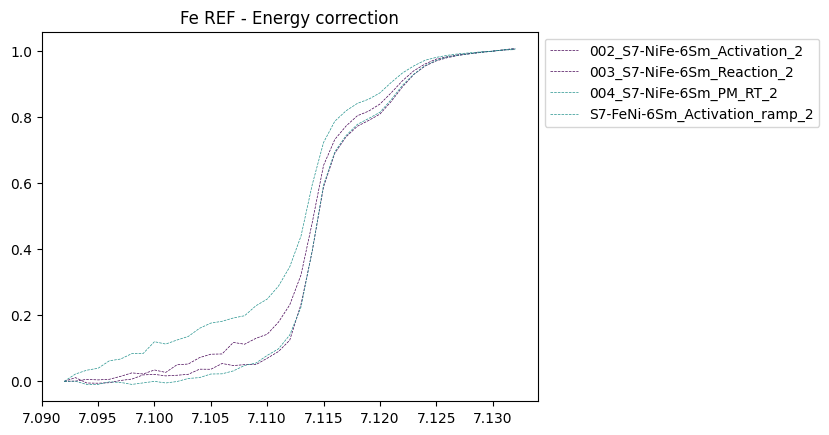

In [3]:
search_string = "Fe_REF_merged"
var1="ionch1" # diode1 / roiX
var2="mcaRt" # AS_IC / mcaLt

monoE_min = 7.08
monoE_max = 7.13
edge = 7.112
smooth = "yes"
# Fe K-edge is at 7.112 KeV

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=0, vmax=len(labeled_files) / 2)
energ_calib_Cu_REF_list = []
for idx, (file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)

    closest_monoE1 = find_closest(monoE_min, result_df['monoE'])
    closest_monoE2 = find_closest(monoE_max, result_df['monoE'])
    signal_min = result_df.loc[result_df['monoE'] == closest_monoE1, f'{var1}/{var2}_mean'].values[0]
    signal_max = result_df.loc[result_df['monoE'] == closest_monoE2, f'{var1}/{var2}_mean'].values[0]
    color = cmap(norm(idx//2))  # Use the same color for pairs

    x = result_df['monoE']
    result_df["I_norm"]=(result_df[f'{var1}/{var2}_mean'] - signal_min)/(signal_max - signal_min)
    y = -0.0*idx + (result_df["I_norm"])
    err = (result_df[f'{var1}/{var2}_std'] - signal_min)/(signal_max - signal_min)
    energy_position_ref_data = find_edge_position(result_df['monoE'].values, result_df["I_norm"].values, monoE_min, monoE_max, smooth)

    #target_value = 0.5
    #idx_before = result_df[result_df["I_norm"] <= target_value].index[-1]
    #idx_after = result_df[result_df["I_norm"] > target_value].index[0]
    #x0, y0 = result_df.loc[idx_before, "I_norm"], result_df.loc[idx_before, 'monoE']
    #x1, y1 = result_df.loc[idx_after, "I_norm"], result_df.loc[idx_after, 'monoE']
    #interpolated_monoE = y0 + (target_value - x0) * (y1 - y0) / (x1 - x0)
    energ_calib_Cu_REF_list.append((label,float(energy_position_ref_data)))


    if label.endswith('_1'):
        plt.plot(x, y, label=label, linewidth=2.5, color=color)
    elif label.endswith('_2'):
        plt.plot(x, y, color=color, linestyle='--', linewidth=0.5, label=label)
    #plt.fill_between(x, y - err,y + err, color=color, alpha=0.2)
#plt.ylim([1.75,2.93])
#plt.xlim([7.15,9.])
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title("Fe REF - Energy correction")

plt.savefig('Fe_REF_NEXAFS.png')


002_S7-NiFe-6Sm_Activation_2: has the edge at 7.1140, the energy shift is -0.002
003_S7-NiFe-6Sm_Reaction_2: has the edge at 7.1140, the energy shift is -0.002
004_S7-NiFe-6Sm_PM_RT_2: has the edge at 7.1140, the energy shift is -0.002
S7-FeNi-6Sm_Activation_ramp_2: has the edge at 7.1140, the energy shift is -0.002


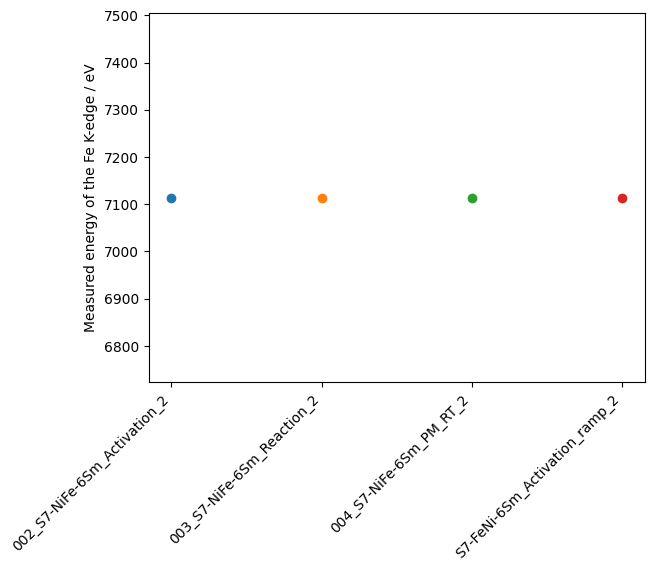

In [4]:
for (lab, en) in energ_calib_Cu_REF_list:
    plt.scatter(lab, en*1000)
    print(f"{lab}: has the edge at {en:.4f}, the energy shift is {edge-en:.3f}")
plt.xticks(rotation=45, ha='right')
plt.ylabel ("Measured energy of the Fe K-edge / eV")
plt.savefig('Fe_REF_energy_shift.png')

In [1]:
search_string = "Fe_NEXAFS_merged"

energy_shifts = [-0.001, -0.002,-0.002,-0.001]

labeled_files= []
for root, dirs, files in os.walk("."):
    files.sort() 
    for i, file in enumerate(files):
        if search_string in file:
            subfolder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            label = f"{subfolder_name}_{i % 2 +1}"
            labeled_files.append((file_path, label))
labeled_files.sort()

for idx,(file_path, label) in enumerate(labeled_files):
    print (label)
    result_df = pd.read_csv(file_path)
    result_df["monoE"] = result_df["monoE"] + energy_shifts[idx]
    result_df.to_csv(file_path[:-4]+"_EC.dat")
    

NameError: name 'os' is not defined